# Business Scenario \#1
The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist|Genre|
|------|-----|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls| Pop|
|Slim Jim Bites| Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [59]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Define functions that perform SQL queries

In [2]:
# a function to run query directly
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# a function to run and not return the query
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

# a function to show the tables in the database
def show_tables():
    with sqlite3.connect('chinook.db') as conn:
        q = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view");'
        print(run_query(q))

### Write a query that returns each genre, with the number of tracks sold in absolute numbers and in percentages


In [3]:
q1=('''
WITH
    il_usa AS
    (
        SELECT
            *
        FROM invoice_line
        INNER JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id
        WHERE invoice.billing_country = 'USA'
    )

SELECT
    genre.name as genre_name,
    COUNT(il_usa.track_id) as tracks_sold,
    ROUND(1.0 * COUNT(il_usa.track_id) / (SELECT SUM(il_usa.quantity) FROM il_usa),2) as tracks_sold_perc
FROM il_usa
INNER JOIN track ON track.track_id = il_usa.track_id
INNER JOIN genre ON track.genre_id = genre.genre_id
GROUP BY 1
ORDER BY 2 DESC
''')
run_query(q1)

,genre_name,tracks_sold,tracks_sold_perc
0,Rock,561,0.53
1,Alternative & Punk,130,0.12
2,Metal,124,0.12
3,R&B/Soul,53,0.05
4,Blues,36,0.03
5,Alternative,35,0.03
6,Latin,22,0.02
7,Pop,22,0.02
8,Hip Hop/Rap,20,0.02
9,Jazz,14,0.01


### Generate charts in absolute number of tracks sold and in percentages

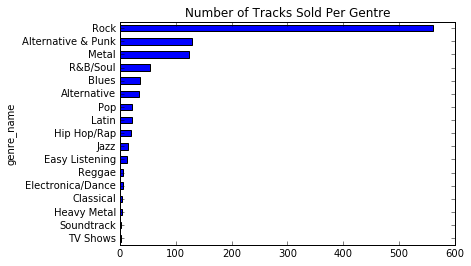

In [4]:
data1 = run_query(q1)
data1.set_index('genre_name',inplace=True)
data1['tracks_sold'].sort_values(ascending=True).plot.barh(title='Number of Tracks Sold Per Gentre',legend=False)

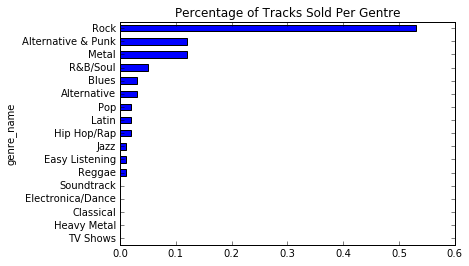

In [5]:
data1['tracks_sold_perc'].sort_values(ascending=True).plot.barh(title='Percentage of Tracks Sold Per Gentre',legend=False)

### Observations \#1
Rock, Alternateive/Punk, Metal, and R&B/Soul made for the overwhelming majority (~77%) of tracks sold at the store. Therefore, we should focus on promoting artists that are within there genres to ensure the deal would generate its higest sales potential.

Since Chinook can promote 3 out of the 4 albums in this deal, Chinook should drop the album that belong to the least popular genre within the group: **Regal's** alubm, which is of Hip-hop (~1.0%).
___

# Business Scenario \#2
Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

You might like to consider whether any extra columns from the employee table explain any variance you see, or whether the variance might instead be indicative of employee performance.

### Investigate the following for each of the sales rep:
- the total sales amount
- number of customers served
- number of tracks sold
- number of years worked
- annualized sales amount

In [6]:
q2 =(
'''
    WITH
        number_customers AS
        (
            SELECT
                customer.support_rep_id,
                count(customer.customer_id) as number_customers
            FROM customer
            GROUP BY 1
        ),
        sales_amount AS
        (
            SELECT
                customer.support_rep_id,
                SUM(invoice.total) as sales_customer
            FROM invoice
            INNER JOIN customer ON customer.customer_id = invoice.customer_id
            INNER JOIN employee ON employee.employee_id = customer.support_rep_id
            GROUP BY 1
        ),
        last_invoice_date AS
        (
            SELECT
                employee.employee_id,
                customer.customer_id,
                invoice.invoice_id,
                max(invoice.invoice_date) as last_invoice_date
            FROM invoice
            INNER JOIN customer ON customer.customer_id = invoice.customer_id
            INNER JOIN employee ON employee.employee_id = customer.support_rep_id
            GROUP BY 1
        )
    
    SELECT
        employee.first_name || " " || employee.last_name as employee_name,
        number_customers.number_customers as number_of_customers,
        sales_amount.sales_customer as sales_amount,
        round((julianday(max(last_invoice_date.last_invoice_date)) - julianday(employee.hire_date))/365,2) as tenure_year,
        round(sales_amount.sales_customer / ((julianday(max(last_invoice_date.last_invoice_date)) - julianday(employee.hire_date))/365.0),2) as annualized_sales        
    FROM employee
    INNER JOIN number_customers ON number_customers.support_rep_id = employee.employee_id
    INNER JOIN sales_amount ON sales_amount.support_rep_id = employee.employee_id
    INNER JOIN last_invoice_date ON last_invoice_date.employee_id = employee.employee_id
    WHERE employee.title = "Sales Support Agent"
    GROUP BY 1
''')
run_query(q2)

,employee_name,number_of_customers,sales_amount,tenure_year,annualized_sales
0,Jane Peacock,21,1731.51,3.75,461.65
1,Margaret Park,20,1584.00,3.66,432.75
2,Steve Johnson,18,1393.92,3.18,438.60


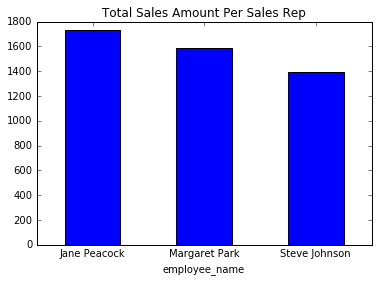

In [7]:
data2 = run_query(q2)
data2.set_index('employee_name',inplace=True)
data2['sales_amount'].plot.bar(rot=0,title='Total Sales Amount Per Sales Rep')

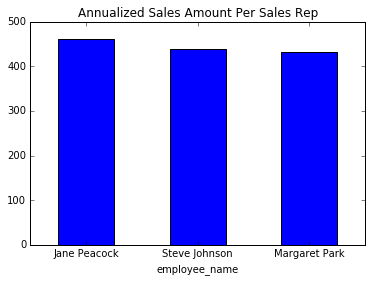

In [8]:
data2['annualized_sales'].sort_values(ascending=False).plot.bar(rot=0,title='Annualized Sales Amount Per Sales Rep')

### Observation \#2
From the records, it shows that Jane Peacock is the top sales rep, followed by Margaret Park, and finally Steven Johnson.

However, such comparison can be misleading, as different sales rep has worked with the company for different tenure durations. Therefore, an annualized sales amount would be a better indicator for their performances.

With that accounted for, it turns out that Jane is still the top sales rep. However, Steven is now the second in rank, followed by Margaret.
___

# Business Scenario \#3
The next task is to analyze the sales data for customers from each different country. We have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.

In particular, we have been directed to calculate data, for each country, on the:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in your analysis.

In [9]:
q3 = ('''
WITH
    inv_cust_sales AS
        (
            SELECT
                CASE
                    WHEN
                        (
                            SELECT
                                COUNT(*)
                            FROM customer
                            WHERE country = c.country
                        ) = 1
                        THEN "Other"
                    ELSE c.country
                END as country,
                c.customer_id,
                invoice.invoice_id,
                invoice.total
            FROM customer as c
            INNER JOIN invoice ON invoice.customer_id = c.customer_id
        )

SELECT
    country,
    number_customers,
    total_sales,
    avg_sales_customer,
    avg_sales_order
FROM
    (
    SELECT
        country,
        count(distinct customer_id) as number_customers,
        SUM(total) as total_sales,
        ROUND(SUM(total) / count(distinct customer_id), 2) as avg_sales_customer,
        ROUND(SUM(total) / count(distinct invoice_id), 2) as avg_sales_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END as sort
    FROM inv_cust_sales
    GROUP BY 1
    ORDER BY sort, 3 DESC
    )
''')
run_query(q3)

,country,number_customers,total_sales,avg_sales_customer,avg_sales_order
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Other,15,1094.94,73.00,7.45


### Visualize the Finding

In [80]:
data3 = run_query(q3)
data3.set_index('country',inplace=True)

# define chart colors for each country
colors = [plt.cm.Set2(i) for i in np.linspace(0,1,data3.shape[0])]

In [94]:
#calculate total sales as percentages
data3['total_sales_perc'] = data3['total_sales'] / data3['total_sales'].sum()

#calculate the +/- in sales of each country vs the avg total sales across the group
data3['mean_dev'] = data3['total_sales'] - data3['total_sales'].mean()

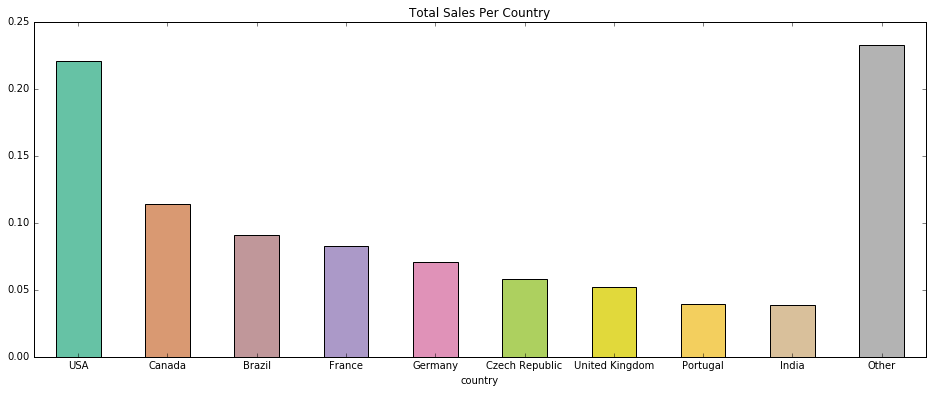

In [92]:
data3['total_sales_perc'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Total Sales Per Country')

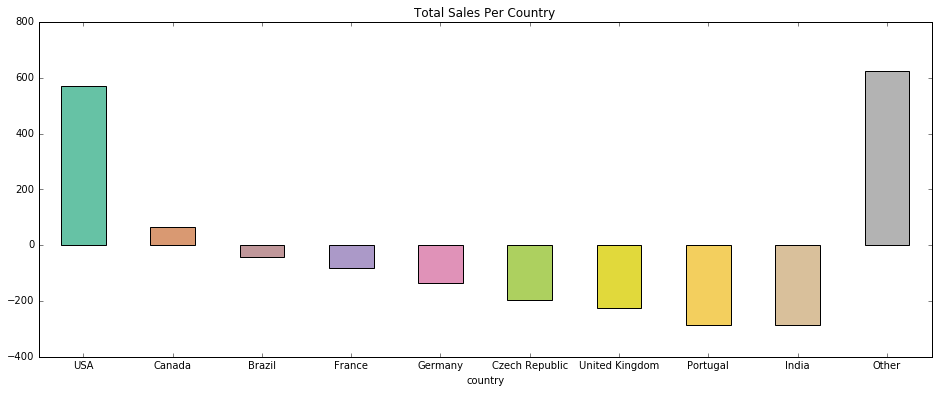

In [86]:

data3['mean_dev'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Total Sales Per Country')

### On the country category: Other
the category "Other" takes up to 25% of the total sales; however it is comprisedof over 15 countries, each with only 1 customer. Due to this nature, let us exclude it from ths analysis.

In [114]:
data4 = data3.drop(['Other'])

In [115]:
data4['total_sales_perc'] = data4['total_sales'] / data4['total_sales'].sum()
data4['mean_dev'] = data4['total_sales'] - data4['total_sales'].mean()
data4

,number_customers,total_sales,avg_sales_customer,avg_sales_order,mean_dev,total_sales_perc
country,,,,,,
USA,13,1040.49,80.04,7.94,638.88,0.287866
Canada,8,535.59,66.95,7.05,133.98,0.148179
Brazil,5,427.68,85.54,7.01,26.07,0.118324
France,5,389.07,77.81,7.78,-12.54,0.107642
Germany,4,334.62,83.66,8.16,-66.99,0.092577
Czech Republic,2,273.24,136.62,9.11,-128.37,0.075596
United Kingdom,3,245.52,81.84,8.77,-156.09,0.067927
Portugal,2,185.13,92.57,6.38,-216.48,0.051219
India,2,183.15,91.57,8.72,-218.46,0.050671


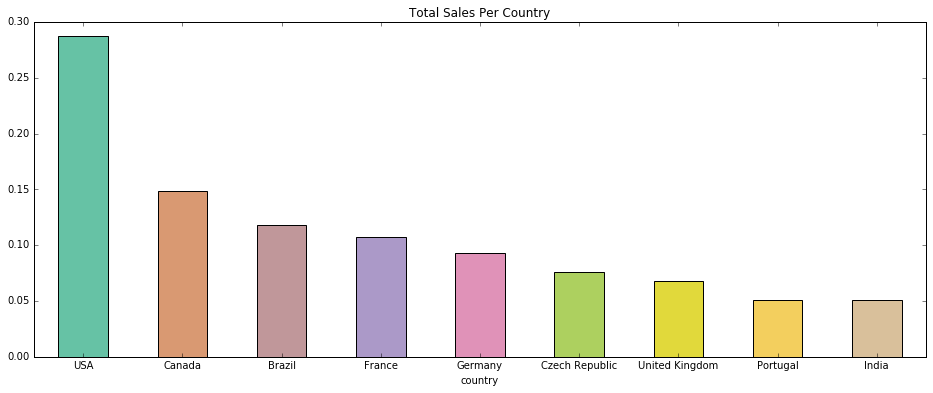

In [116]:
data4['total_sales_perc'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Total Sales Per Country')

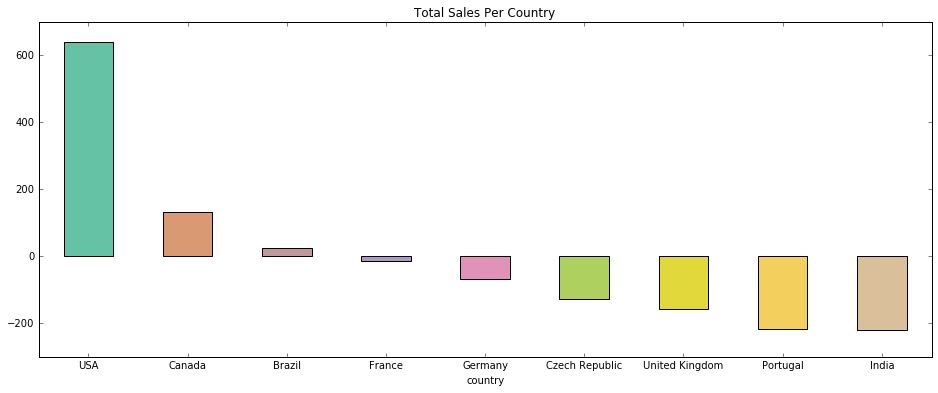

In [117]:
data4['mean_dev'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Total Sales Per Country')

### Observations So Far
USA, Canada, Brazil, and France are countries where the sales are above average. On the other hand, Germany, Czech Rep, UK, Portugal, and India lag behind the average.

USA, Canada, Germany, and UK have similar Social Economic Status; however, these countries differ in population size, which could have been a factor in influencing the sales amount.

Let's investigate deeper by looking at the sales amount per customer and per order.

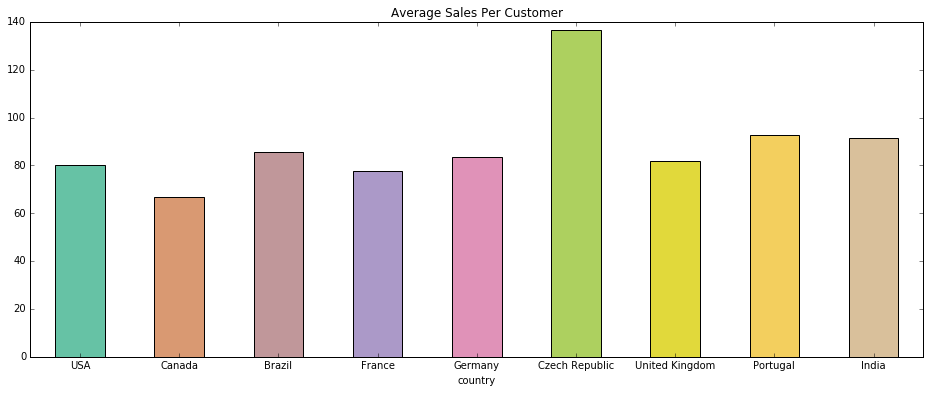

In [118]:
data4['avg_sales_customer'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Average Sales Per Customer')

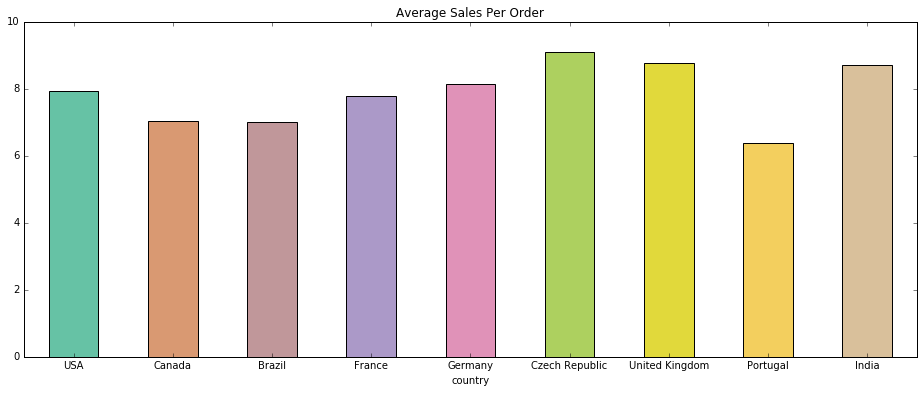

In [120]:
data4['avg_sales_order'].plot.bar(color=colors,rot=0,figsize=(16,6),title='Average Sales Per Order')

### Observations So Far
 In terms of sales amount per person and per order, there are actually no significant differences between customers in USA, Canada, Germany, and UK. If anything those in Canada bought less on a per customer and per order basis.
 
 It is also surprising to find that customers in Czech Republic are the top purchasers in both per customer and per order basis.
 ___

# Recommendations
### Action 1: Increase Awareness
From the records, it shows that customers in Canada are more frugal with their purchases. Since it is more difficult to change individual behaviors, the company would have better chance of success by increasing the base of purchasers.

Therefore, in order to increase total sales in Canada, the company should target the general public for its marketing campaign.

### Actoin 2: Targeted Promotion
On the other hand, the company should target the big rollers in Czech Republic. Since there customers are already generous with their purchases, the company should target these customers with personalized marketing campaign.
___

# Business Scenario \#4
The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

purchase a whole album
purchase a collection of one or more individual tracks.
The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.
In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [183]:
# description of algorithm
# 1. Generate a table that contains all the invoice_id and the first track_id
    # associated with it. Use this table as the base main table.
# 2. Using the invoice_id in step 1, generate a table from invoice_line that 
    # contains all the track_id purchased.
# 3. Using the track_id in step 1, find its matching album, then generate a 
    # table containing all the tracks from that album
# 4. Now the tables from step 2 and 3 should contain the same column structures.
    # Conduct ( (STEP2 EXCEPT STEP3) is NULL and (STEP3 EXCEPT STEP2) is NULL)...
    # If evaluated as "YES", it means the associated invoice was purchased as
    # a whole album.
# 5. Assign the outcomes from step 4 back into the main table in step 1.
# 6. Using the new table from step 5 to calculate COUNT for the Yes/No groups

In [180]:
q4 = ('''
WITH
    main AS
        (
            SELECT
                 il.invoice_id invoice_id,
                 MIN(il.track_id) first_track_id
             FROM invoice_line il
             GROUP BY 1
         )
SELECT
    main.is_album,
    COUNT(main.invoice_id) as number_of_purchases,
    ROUND(1.0 * count(main.invoice_id) / (SELECT COUNT(*) FROM main), 2) as number_of_purchases_perc
FROM
    (
        SELECT
            main.*,
            CASE
                WHEN
                    (
                    SELECT
                        t2.track_id
                    FROM track as t2
                    WHERE
                        (
                            SELECT
                                t1.album_id
                            FROM track as t1
                            WHERE t1.track_id = main.first_track_id
                        ) = t2.album_id
                    
                    EXCEPT
                    
                    SELECT
                        il.track_id
                    FROM invoice_line as il
                    WHERE il.invoice_id = main.invoice_id
                    ) IS NULL
                
                    AND
                    (
                    SELECT
                        il.track_id
                    FROM invoice_line as il
                    WHERE il.invoice_id = main.invoice_id
                    
                    EXCEPT
                    
                    SELECT
                        t2.track_id
                    FROM track as t2
                    WHERE
                        (
                            SELECT
                                t1.album_id
                            FROM track as t1
                            WHERE t1.track_id = main.first_track_id
                        ) = t2.album_id
                    ) IS NULL
                    THEN "Yes"
                    ELSE "No"
            END as is_album
        FROM main
    ) as main
GROUP BY 1
''')
run_query(q4)

,is_album,number_of_purchases,number_of_purchases_perc
0,No,500,0.81
1,Yes,114,0.19


# Recommendation
From the records, it shows that the 19% of the purchases were of album purchase.

If the management were to revise its purchasing policy, it would mean that the company would potentially lose close to a fifth of its sales total, as it was established that customers are unlikely to add at songs from an album individually into their purchases.

Base on this possibility, it is best to avoid the proposed change in purchasing policy.